In [128]:
import os
import numpy as np
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
os.makedirs('plots', exist_ok=True)

## Getting and parsing the TCR and MHC PWM files 

In [129]:
# TCRPWM_root = 'pwm_csv_files/hcnn_fixed_structure_top_200_of_300_by_tcrdock_pae/hcnn_pyrosetta_noise=0p0'
TCRPWM_root = 'pwm_csv_files/hcnn_fixed_structure/hcnn_pyrosetta_noise=0p0'

# MHC_PWM_root = 'pwm_csv_files/mhc_motifs'
MHC_PWM_root = 'pwm_csv_files/mhc_hcnn_fixed_structure/hermes_py_000'

pdbs_with_TCRPWM = [filename.split('__')[0] for filename in os.listdir(TCRPWM_root) if filename.endswith('.csv')]
TCRPWMFiles = [os.path.join(TCRPWM_root, filename) for filename in os.listdir(TCRPWM_root) if filename.endswith('.csv')]

pdbs_with_MHC_PWM = [filename.split('__')[0] for filename in os.listdir(MHC_PWM_root) if filename.endswith('.csv')]
alleles_with_MHC_PWM = [filename.split('__')[2].strip('.csv') for filename in os.listdir(MHC_PWM_root) if filename.endswith('.csv')]
MHCPWMFiles = [os.path.join(MHC_PWM_root, filename) for filename in os.listdir(MHC_PWM_root) if filename.endswith('.csv')]

In [130]:
# info_df = pd.read_csv('hcnn_logos/ternary_templates_v2__with_peptide_info.tsv', sep='\t')

# human_class_I_pdbs = set(info_df[info_df['organism'] == 'human'].loc[info_df['mhc_class'] == 1]['pdbid'].values)
# mouse_class_I_pdbs = info_df[info_df['organism'] == 'mouse'].loc[info_df['mhc_class'] == 1]['pdbid'].values

# IncommonPDB = list(set(pdbs_with_TCRPWM).intersection(set(pdbs_with_MHC_PWM)).intersection(set(human_class_I_pdbs).union(set(mouse_class_I_pdbs))))

def is_class_I_human(allele):
    return allele[:2] in {'A*', 'B*', 'C*'}

def is_class_I_mouse(allele):
    return allele[0] in {'H'}

IncommonPDB = []
human_class_I_pdbs = []
mouse_class_I_pdbs = []
for pdb, allele in zip(pdbs_with_MHC_PWM, alleles_with_MHC_PWM):
    if pdb in pdbs_with_TCRPWM:
        if is_class_I_human(allele):
            human_class_I_pdbs.append(pdb)
            IncommonPDB.append(pdb)
        elif is_class_I_mouse(allele):
            mouse_class_I_pdbs.append(pdb)
            IncommonPDB.append(pdb)
        

## Functions calculating entropy of a vector and the DKL between two vectors.

In [131]:
def entropy(p):
    p = p[p > 0]
    return -np.sum(p * np.log2(p))

def KLdiv(p1, p2):
    mask = (p1 > 0) & (p2 > 0)
    p1 = p1[mask]
    p2 = p2[mask]
    return np.sum(p1 * np.log2(p1 / p2))

## Defining *dictionaries* that take the PDB ID and give the pwm, peptide, pwm length for TCRPWMs, and also HLA identity for the MHCPWMs

In [132]:
TCRPWMs = {}
for file in TCRPWMFiles:
    pdb = file.split('/')[-1].split('__')[0]
    wt_peptide = file.split('/')[-1].split('__')[1].split('.')[0]
    pwm_df = pd.read_csv(file, index_col=0)
    length = len(wt_peptide)
    TCRPWMs[pdb] = (pwm_df.values, wt_peptide, length)

pdb_to_MHC_and_length= {}
for file in MHCPWMFiles:
    pdb = file.split('/')[-1].split('__')[0]
    wt_peptide = file.split('/')[-1].split('__')[1]
    mhc = file.split('/')[-1].split('__')[2].split('.')[0]
    pdb_to_MHC_and_length[pdb] = (mhc, len(wt_peptide))

print(pdb_to_MHC_and_length)

MHCPWMs = {}
for file in MHCPWMFiles:
    pdb = file.split('/')[-1].split('__')[0]
    wt_peptide = file.split('/')[-1].split('__')[1]
    mhc = file.split('/')[-1].split('__')[2].split('.')[0]
    pwm_df = pd.read_csv(file, index_col=0)
    length = len(wt_peptide)
    MHCPWMs[pdb] = (pwm_df.values, wt_peptide, length, mhc)

{'1fo0': ('H2Kb', 8), '6avg': ('B*07:02', 13), '2iam': ('DRA*01:01,DRB1*01:01', 11), '2bnq': ('A*02:01', 9), '4ftv': ('A*02:01', 9), '7n1f': ('A*02:01', 9), '5wkf': ('A*11:01', 10), '6rsy': ('A*02:01', 9), '2oi9': ('H2Ld', 9), '2vlk': ('A*02:01', 9), '6rpb': ('A*02:01', 9), '2f54': ('A*02:01', 9), '5hyj': ('A*02:01', 10), '5wlg': ('H2Db', 9), '5yxu': ('A*02:01', 10), '3vxr': ('A*24:02', 10), '5c0a': ('A*02:01', 10), '6eqa': ('A*02:01', 9), '3dxa': ('B*44:05', 10), '4nhu': ('H2Ld', 12), '5jhd': ('A*02:01', 9), '4g8g': ('B*27:05', 10), '5tez': ('A*02:01', 9), '2bnr': ('A*02:01', 9), '4mvb': ('H2Ld', 9), '1qsf': ('A*02:01', 9), '4e41': ('DRA*01:01,DRB1*01:01', 11), '4ozh': ('DQA1*05:01,DQB1*02:01', 11), '5e6i': ('A*02:01', 9), '4ozf': ('DQA1*05:01,DQB1*02:01', 11), '3d39': ('A*02:01', 8), '4mnq': ('A*02:01', 9), '1g6r': ('H2Kb', 8), '4h1l': ('DRA*01:01,DRB3*03:01', 11), '6cqn': ('DRA*01:01,DRB1*11:01', 11), '1ao7': ('A*02:01', 9), '3mv9': ('B*35:01', 11), '2wbj': ('DRA*01:01,DRB1*15:01', 

## Calculating Total Entropy (sum over positions), DKL and also position-wise entropies for both MHC and TCR

In [133]:
AllEntropies = []
for pdb in IncommonPDB:
    mhc_pwm = MHCPWMs[pdb][0]
    tcr_pwm = TCRPWMs[pdb][0]

    mhc_entropy_per_pos = np.array([entropy(mhc_pwm[i]) for i in range(mhc_pwm.shape[0])])
    tcr_entropy_per_pos = np.array([entropy(tcr_pwm[i]) for i in range(tcr_pwm.shape[0])])
    dkl_per_pos = np.array([KLdiv(mhc_pwm[i], tcr_pwm[i]) for i in range(mhc_pwm.shape[0])])
    mhc_entropy = np.sum(mhc_entropy_per_pos)
    tcr_entropy = np.sum(tcr_entropy_per_pos)
    dkl = np.sum(dkl_per_pos)

    AllEntropies.append((pdb, mhc_entropy_per_pos, tcr_entropy_per_pos, dkl_per_pos, mhc_entropy, tcr_entropy, dkl, mhc_pwm, tcr_pwm))

# ## this is true only for the PWMs coming from MHC Motif Atlas, so run this code only then
# # save entropies specific to MHC and peptide length, assert that the MHC entropies are the same for equivalent MHCs
# MHC_length_to_entropies = {}
# for (pdb, mhc_entropy_per_pos, tcr_entropy_per_pos, dkl_per_pos, mhc_entropy, tcr_entropy, dkl) in AllEntropies:
#     MHC_and_length = pdb_to_MHC_and_length[pdb]
#     if MHC_and_length not in MHC_length_to_entropies:
#         MHC_length_to_entropies[MHC_and_length] = mhc_entropy_per_pos, tcr_entropy_per_pos, dkl_per_pos, mhc_entropy, tcr_entropy, dkl
#     else:
#         assert MHC_length_to_entropies[MHC_and_length][3] == mhc_entropy

# ## if using HERMES' PWMs instead, average the PWMs at the log-probability level
# MHC_length_to_entropies = {}
# for (pdb, mhc_entropy_per_pos, tcr_entropy_per_pos, dkl_per_pos, mhc_entropy, tcr_entropy, dkl) in AllEntropies:
#     MHC_and_length = pdb_to_MHC_and_length[pdb]
#     if MHC_and_length not in MHC_length_to_entropies:
#         MHC_length_to_entropies[MHC_and_length] = mhc_entropy_per_pos, tcr_entropy_per_pos, dkl_per_pos, mhc_entropy, tcr_entropy, dkl
#     else:
#         assert MHC_length_to_entropies[MHC_and_length][3] == mhc_entropy


In [134]:
print(TCRPWMs['3tjh'][0])

[[1.15189439e-01 6.79962466e-01 3.45750886e-03 1.81075427e-01
  1.38999615e-03 2.78907090e-03 8.82559267e-04 8.27322690e-03
  6.22889151e-05 1.60201854e-04 4.96412338e-03 4.64679246e-05
  2.89779022e-04 2.14343821e-04 1.12493363e-03 2.57742716e-05
  3.91658487e-06 8.45706885e-05 3.22305314e-06 6.82691666e-07]
 [1.92209225e-07 4.75225408e-06 3.95481858e-07 1.73200142e-06
  9.99992649e-01 3.50569849e-08 7.96880333e-09 7.11772289e-08
  5.55557399e-10 7.24111636e-10 1.46013738e-08 3.83963353e-10
  4.51202617e-08 5.52038150e-09 9.36960452e-08 3.33444286e-10
  1.72368348e-11 3.76262056e-09 3.29707125e-11 1.09586867e-13]
 [5.57421508e-08 1.55485593e-06 1.09422540e-04 1.04243841e-05
  1.19000595e-06 3.04250646e-05 5.61580412e-05 8.61649765e-05
  3.47177853e-04 9.88503024e-01 9.28911805e-04 2.11831030e-03
  6.52571268e-03 1.80877965e-04 8.01614162e-04 2.28672489e-04
  7.64083492e-06 5.77316307e-05 3.16992217e-06 1.76037269e-06]
 [6.69568607e-08 3.84210253e-06 4.65110637e-05 4.89819255e-05
  5.2

## Separating entropies by humans vs. mice

In [135]:
HumanAllEntropies = []
MouseAllEntropies = []
for entropies in AllEntropies:
    pdb = entropies[0]
    if pdb in human_class_I_pdbs:
        HumanAllEntropies.append(entropies)
    else:
        MouseAllEntropies.append(entropies)

## Plotting code

In [136]:
def plots(AllEntropiesDesired):

    AllEntropiesDesired_by_MHC_and_length = {}
    AllEntropiesDesired_by_MHC = {}
    for entropies in AllEntropiesDesired:
        pdb = entropies[0]
        mhc_and_length = pdb_to_MHC_and_length[pdb]
        if mhc_and_length not in AllEntropiesDesired_by_MHC_and_length:
            AllEntropiesDesired_by_MHC_and_length[mhc_and_length] = [entropies]
        else:
            AllEntropiesDesired_by_MHC_and_length[mhc_and_length].append(entropies)
        
        MHC = mhc_and_length[0]
        if MHC not in AllEntropiesDesired_by_MHC:
            AllEntropiesDesired_by_MHC[MHC] = [entropies]
        else:
            AllEntropiesDesired_by_MHC[MHC].append(entropies)


    ## boxplots

    # tcr-pmhc entropy
    fig, ax = plt.subplots()
    mhcs, entropies_to_plot = [], []
    for mhc, entropies_list in AllEntropiesDesired_by_MHC.items():
        mhcs.append(mhc)
        curr_entropies_to_plot = []
        for entropies in entropies_list:
            curr_entropies_to_plot.append(entropies[5]) # tcr_entropy
        entropies_to_plot.append(curr_entropies_to_plot)
    ax.boxplot(entropies_to_plot, vert=False)
    ax.set_yticklabels(mhcs)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('Total Entropy pMHC-TCR complex [bits]', fontsize=16)
    plt.tight_layout()
    plt.show()
    plt.close()

    # mean per-residue entropy reduction
    fig, ax = plt.subplots()
    mhcs_and_length, entropies_to_not_plot_yet = [], []

    for mhc_and_length, entropies_list in AllEntropiesDesired_by_MHC_and_length.items():
        mhcs_and_length.append(mhc_and_length)
        curr_entropies_to_plot = []
        for entropies in entropies_list:
            # curr_entropies_to_plot.append(entropies[6] - entropies[5]) # dkl - tcr_entropy
            curr_entropies_to_plot.append(np.mean((entropies[1] - entropies[2])))
            # print(entropies_to_not_plot_yet[-1])
        entropies_to_not_plot_yet.append(curr_entropies_to_plot)

    mhc_to_entropies_to_plot = {}
    for mhc_and_length, data in zip(mhcs_and_length, entropies_to_not_plot_yet):
        mhc = mhc_and_length[0]
        if mhc not in mhc_to_entropies_to_plot:
            mhc_to_entropies_to_plot[mhc] = data
        else:
            mhc_to_entropies_to_plot[mhc].extend(data)
    mhcs, entropies_to_plot = zip(*list(mhc_to_entropies_to_plot.items()))
    ax.boxplot(entropies_to_plot, vert=False)
    ax.set_yticklabels(mhcs)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('Mean (per residue) Entropy Reduction [bits]', fontsize=16)
    plt.tight_layout()
    plt.show()
    plt.close()

    ## histogram
    plt.hist([data for data2 in entropies_to_plot for data in data2], bins=7)
    plt.xticks(fontsize=14)
    plt.xlabel('Mean Entropy Reduction [bits]', fontsize=16)
    plt.show()

    import math

    MHC_and_length_list = sorted(list(AllEntropiesDesired_by_MHC_and_length.keys()))


    num_plots = len(MHC_and_length_list)
    ncols = math.floor(math.sqrt(num_plots))
    nrows = math.ceil(num_plots / ncols)
    colsize = 4
    rowsize = 3
    fig, axs = plt.subplots(figsize=(ncols * colsize, nrows * rowsize), ncols=ncols, nrows=nrows, sharey=True)

    for i, (ax, mhc_and_length) in enumerate(zip(axs.flatten(), MHC_and_length_list)):
        entropies = AllEntropiesDesired_by_MHC_and_length[mhc_and_length]
        num_pdbs = len(entropies)

        # line with mhc_entropy_per_pos
        mhc_entropy_per_pos = entropies[0][1]

        # boxplots
        tcr_entropies_per_pos = list(np.vstack([entropies[i][2] for i in range(num_pdbs)]).T)

        ax.boxplot(tcr_entropies_per_pos)
        ax.plot(range(1, len(mhc_entropy_per_pos) + 1), mhc_entropy_per_pos, color='tab:blue')
        ax.set_title(f'{mhc_and_length[0]}; #:{num_pdbs}; length={mhc_and_length[1]}', fontsize=16)
        ax.set_xlabel('Position', fontsize=16)
        # ax.set_xticks(range(len(mhc_entropy_per_pos)))
        # ax.set_xticklabels(range(1, len(mhc_entropy_per_pos) + 1))

        # when a row, label y-axis
        if i % ncols == 0:
            ax.set_ylabel('Entropy [bits]', fontsize=16)
        
        ax.tick_params(labelsize=16)

    plt.tight_layout()
    plt.show()



def plots_pretty(AllEntropiesDesired, figsize, width_ratios, name):

    AllEntropiesDesired_by_MHC_and_length = {}
    AllEntropiesDesired_by_MHC = {}
    for entropies in AllEntropiesDesired:
        pdb = entropies[0]
        mhc_and_length = pdb_to_MHC_and_length[pdb]
        if mhc_and_length not in AllEntropiesDesired_by_MHC_and_length:
            AllEntropiesDesired_by_MHC_and_length[mhc_and_length] = [entropies]
        else:
            AllEntropiesDesired_by_MHC_and_length[mhc_and_length].append(entropies)
        
        # MHC = mhc_and_length[0]
        # if MHC not in AllEntropiesDesired_by_MHC:
        #     AllEntropiesDesired_by_MHC[MHC] = [entropies]
        # else:
        #     AllEntropiesDesired_by_MHC[MHC].append(entropies)

    ## GOAL: merge the MHC PWMs of the same MHC and length, instead of considering them individually
    for mhc_and_length in AllEntropiesDesired_by_MHC_and_length.keys():
        entropies_list = AllEntropiesDesired_by_MHC_and_length[mhc_and_length]

        # average mhc pwms
        averaged_mhc_pwm = softmax(np.mean([np.log(entropies[-2]) for entropies in entropies_list], axis=0), axis=1)
        # averaged_mhc_pwm = np.mean([entropies[-2] for entropies in entropies_list], axis=0)

        # while I'm at it, plot the averaged mhc pwm in a logoplot
        import logomaker
        
        ind_to_ol_size = {0: 'G', 1: 'A', 2: 'C', 3: 'S', 4: 'P', 5: 'T', 6: 'V', 7: 'D', 8: 'I', 9: 'L', 10: 'N', 11: 'M', 12: 'Q', 13: 'K', 14: 'E', 15: 'H', 16: 'F', 17: 'R', 18: 'Y', 19: 'W'}

        # make the logo show information content, not probability
        information = np.log2(20) + np.sum(averaged_mhc_pwm * np.log2(averaged_mhc_pwm + 1e-10), axis=1)

        information_adjusted_average_mhc_pwm = averaged_mhc_pwm * information[:, np.newaxis]

        information_adjusted_average_mhc_pwm_df = pd.DataFrame(information_adjusted_average_mhc_pwm, index=range(1, averaged_mhc_pwm.shape[0]+1), columns=[ind_to_ol_size[ind] for ind in range(20)])

        
        # make the figure
        fig, ax = plt.subplots(figsize=(10, 2))
        ax.set_ylim(0, np.log2(20))
        logomaker.Logo(information_adjusted_average_mhc_pwm_df, ax=ax)
        plt.tight_layout()
        plt.savefig(os.path.join(MHC_PWM_root, f'{"__".join(map(str, mhc_and_length))}.png'))
        plt.close()

        # substitute the individual pwms with the averaged one
        new_entropies_list = []
        for entropies in entropies_list:
            (pdb, mhc_entropy_per_pos, tcr_entropy_per_pos, dkl_per_pos, mhc_entropy, tcr_entropy, dkl, mhc_pwm, tcr_pwm) = entropies

            mhc_entropy_per_pos = np.array([entropy(averaged_mhc_pwm[i]) for i in range(averaged_mhc_pwm.shape[0])])
            tcr_entropy_per_pos = np.array([entropy(tcr_pwm[i]) for i in range(tcr_pwm.shape[0])])
            dkl_per_pos = np.array([KLdiv(averaged_mhc_pwm[i], tcr_pwm[i]) for i in range(averaged_mhc_pwm.shape[0])])
            mhc_entropy = np.sum(mhc_entropy_per_pos)
            tcr_entropy = np.sum(tcr_entropy_per_pos)
            dkl = np.sum(dkl_per_pos)

            new_entropies_list.append((pdb, mhc_entropy_per_pos, tcr_entropy_per_pos, dkl_per_pos, mhc_entropy, tcr_entropy, dkl, averaged_mhc_pwm, tcr_pwm))
        
        AllEntropiesDesired_by_MHC_and_length[mhc_and_length] = new_entropies_list

        MHC = mhc_and_length[0]
        if MHC not in AllEntropiesDesired_by_MHC:
            AllEntropiesDesired_by_MHC[MHC] = AllEntropiesDesired_by_MHC_and_length[mhc_and_length]
        else:
            AllEntropiesDesired_by_MHC[MHC] += AllEntropiesDesired_by_MHC_and_length[mhc_and_length]


    ## boxplots

    fontsize = 18

    # tcr-pmhc entropy
    fig = plt.figure(figsize=figsize)

    gs = mpl.gridspec.GridSpec(1, 2, width_ratios=width_ratios, wspace=0.0)  # Adjust ratios and spacing

    mhcs, tcr_entropies_to_plot, mhc_entropies_to_plot = [], [], []
    mhc_list = sorted(AllEntropiesDesired_by_MHC.keys())
    for mhc in mhc_list:
        entropies_list = AllEntropiesDesired_by_MHC[mhc]
        if len(entropies_list) < 2:
            continue
        curr_tcr_entropies_to_plot = []
        curr_mhc_entropies_to_plot = []
        for entropies in entropies_list:
            curr_tcr_entropies_to_plot.append(entropies[5]) # tcr_entropy
            curr_mhc_entropies_to_plot.append(entropies[4]) # mhc_entropy
        mhcs.append(mhc)
        tcr_entropies_to_plot.append(curr_tcr_entropies_to_plot)
        mhc_entropies_to_plot.append(curr_mhc_entropies_to_plot)
    
    tcr_entropies_to_plot_flat = [ent for sublist in tcr_entropies_to_plot for ent in sublist]
    mhc_entropies_to_plot_flat = [ent for sublist in mhc_entropies_to_plot for ent in sublist]
    print(round(np.mean(np.array(tcr_entropies_to_plot_flat))), round(np.median(np.array(tcr_entropies_to_plot_flat))))
    print(round(np.mean(np.array(mhc_entropies_to_plot_flat))), round(np.median(np.array(mhc_entropies_to_plot_flat))))
    print()
    print(round(np.mean([np.median(x) for x in tcr_entropies_to_plot])), round(np.median([np.median(x) for x in tcr_entropies_to_plot])))
    print(round(np.mean([np.median(x) for x in mhc_entropies_to_plot])), round(np.median([np.median(x) for x in mhc_entropies_to_plot])))
    
    num_structures_per_mhc = [len(x) for x in tcr_entropies_to_plot]
    minimum_per_mhc = [min(x) for x in tcr_entropies_to_plot]

    ax1 = plt.subplot(gs[0])

    box = ax1.boxplot(tcr_entropies_to_plot, 
            vert=False,       # Horizontal box plot
            whis=[0, 100],   # Set whiskers to the range of the data (min and max)
            showmeans=False, # Do not show the mean marker
            showcaps=True,   # Show caps at the ends of whiskers
            patch_artist=True, # For box color
            widths=0.6,      # Width of the box
            boxprops=dict(color="none"), 
            whiskerprops=dict(color="grey"),
            capprops=dict(color="grey"),
            medianprops=dict(color="white")) # Style for the median line

    # scatterplot of individual entropy values, make them in front of boxplot
    for i, (mhc, entropies) in enumerate(zip(mhcs, tcr_entropies_to_plot)):
        noise = np.random.normal(0, 0.1, len(entropies))
        y = np.array([i + 1] * len(entropies)) + noise
        ax1.scatter(entropies, y, color='black', edgecolor='none', s=20, alpha=0.3, zorder=10)
    
    xlim = ax1.get_xlim()
    ax1.set_xlim([xlim[0] - 1.0, xlim[1]])

    # Customize the facecolor of each box
    colors = ['#E57373', '#FF8C42', '#FFD700', '#A2C94E', '#48A14D', '#4FBDBA', '#4A90E2', '#3C64B1', '#5B4EBC', '#9063CD', '#2C3E88']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # add number of structures per MHC as text to the left of the left whisker
    for i, (mhc, num_structures, minimum) in enumerate(zip(mhcs, num_structures_per_mhc, minimum_per_mhc)):
        ax1.text(minimum - 0.25, i + 1, f'{num_structures}', fontsize=fontsize-2, va='center', ha='right')

    ax1.set_yticklabels(mhcs)
    ax1.tick_params(axis='x', which='major', labelsize=fontsize-2)
    ax1.tick_params(axis='y', which='major', labelsize=fontsize)
    ax1.set_xlabel('peptide entropy in complex\nw/ TCR-MHC [bits]', fontsize=fontsize)

    # show all integer xticks withput skipping, but only the labels two at a time
    xlim = ax1.get_xlim()
    xticks = np.arange(int(xlim[0])+1, int(xlim[1])+1)
    xtick_labels = [str(int(x)) if x % 2 == 0 else '' for x in xticks]
    xtick_labels[0] = ''
    xtick_labels[-1] = ''
    ax1.set_xticks(xticks, xtick_labels)


    ax2 = plt.subplot(gs[1])

    # compute mean mhc entropy per MHC - this will effectively be a weighted average across the peptide lengths
    mean_mhc_entropies = [np.mean(x) for x in mhc_entropies_to_plot]
    stddev_mhc_entropies = [np.std(x) for x in mhc_entropies_to_plot]
    std_error_mhc_entropies = [stddev / np.sqrt(len(x)) for x, stddev in zip(mhc_entropies_to_plot, stddev_mhc_entropies)]

    ax2.barh(mhcs, mean_mhc_entropies, color=colors, height=0.5)

    # add errorbars
    # use standard deviation since we're interested in showing the spread of the distribution, not the error of the mean
    for i, (mhc, mean, std) in enumerate(zip(mhcs, mean_mhc_entropies, stddev_mhc_entropies)):
        ax2.errorbar(mean, i, xerr=std, fmt='', color='black', capsize=0, capthick=0)

    ax2.tick_params(axis='x', which='major', labelsize=fontsize-2)
    
    # set y-label but on the right side
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel('peptide entropy in complex\nw/ MHC [bits]', rotation=270, fontsize=fontsize, labelpad=42)

    ax2.set_yticklabels([])

    # way too fancy a piece of code to set tick labels where they don't clutter
    max_val = max(mean_mhc_entropies)
    num_desired_ticks = 2

    start = (max_val / num_desired_ticks) // 10 * 10
    if (max_val / num_desired_ticks) % 10 > 3:
        spacing = start + 10
    else:
        spacing = start
    
    tick_labels = [start]
    for i in range(1, num_desired_ticks):
        tick_labels.append(tick_labels[-1] + spacing)
    ticks = np.arange(1, (max_val // 10)+1) * 10

    tick_labels_extended = []
    for tick in ticks:
        if tick not in tick_labels:
            tick_labels_extended.append('')
        else:
            tick_labels_extended.append(int(tick))

    ax2.set_xticks(ticks, tick_labels_extended)

    plt.tight_layout()
    plt.savefig(f'plots/{name}_tcr_mhc_entropy.png')
    plt.savefig(f'plots/{name}_tcr_mhc_entropy.pdf')
    plt.show()
    plt.close()


## Analysis for Mice
### first  group  by  MHC  types, plot  distribution  of  total  entropy and mean (per residue) entropy and the entropy reduction (relative to that of MHC)
### Second, show position-wise entropy for MHC and TCRs:

#### These are rescaled / shifted upwards maybe???

10 10
18 19

10 10
19 19


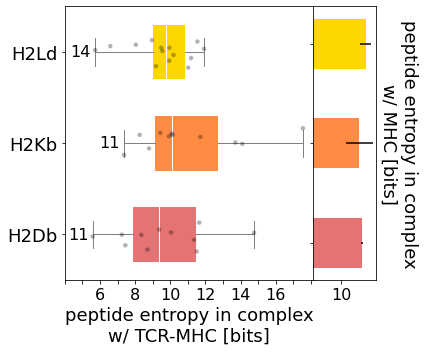

In [137]:
plots_pretty(MouseAllEntropies, (6, 5), (4, 1), 'mouse')

## Analysis for Human
### first  group  by  MHC  types, plot  distribution  of  total  entropy and mean (per residue) entropy and the entropy reduction (relative to that of MHC)
### Second, show position-wise entropy for MHC and TCRs:

#### These are rescaled / shifted upwards maybe???

10 10
19 21

10 10
15 14


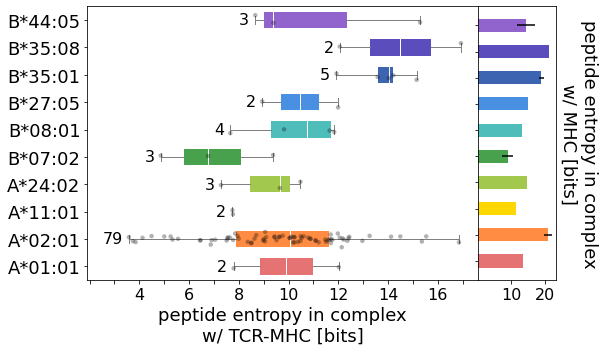

In [138]:
plots_pretty(HumanAllEntropies, (8.5, 5), (5, 1), 'human')

Note how, for A*01:01, which has two structures corresponding to mage and titin peptides, the PWM predicted by HERMES-fixed still bears the signature of E-DPI.

Now, we actually know for a fact that the D is preferred by that MHC allele. The P prevalence is likely due to the fact that proline induces a specific conformation of the peptide backbone, which no other amino-acid would induce, so HERMES wants to keep that. And the initial E? it's strange. Maybe TCR binding induces that E to be buried in there and to interact. Or maybe, the E there happens to make for a very strong MHC binding, but it's not as necessary for TCR binding in principle.
And that Ile? I am not sure, the side-chain is pointing outwards... a hydrophobic at the surface! HERMES shouldn't be predicting this.

I think two things now:
    - I think our TCR entropies are super unreliable when in small numbers, as they are heavily influenced by the peptide conformation, and by the MHC binding of the specific peptide sequences
    - I think maybe a better measurement would be entropy reduction computed by the model, with and without the TCR, structure by structure
    - I don't think we can easily refine MHC presentation with HERMES. In the limit of a lot of pMHC structures with high peptide diversity and conformational diversity, then perhaps yes. But it was a minor comment of the reviewer anyway

In [266]:
import os


mhc_names = [x.strip('.csv') for x in os.listdir('pwm_csv_files/mhc_motifs') if x.endswith('.csv')]

allele_to_pdp_peptide_list = {}

for mhc_name in mhc_names:

    pdb, wt_seq, mhc_allele = mhc_name.split('__')

    if os.path.exists(f'pwm_csv_files/hcnn_fixed_structure/hcnn_pyrosetta_noise=0p0/{pdb}__{wt_seq}.csv'):
        if mhc_allele not in allele_to_pdp_peptide_list:
            allele_to_pdp_peptide_list[mhc_allele] = []
        
        allele_to_pdp_peptide_list[mhc_allele].append((pdb.upper(), wt_seq))

print()
for allele in sorted(allele_to_pdp_peptide_list.keys()):
    print(allele)
    print('; '.join([str(x) for x in allele_to_pdp_peptide_list[allele]]).replace("'", ""))
    # print(' '.join([f'{x[0]}-{x[1]}' for x in allele_to_pdp_peptide_list[allele]]).replace("'", ""))
    print()


A*01:01
(5BS0, ESDPIVAQY); (5BRZ, EVDPIGHLY)

A*02:01
(2BNQ, SLLMWITQV); (4FTV, LLFGYPVYV); (7N1F, YLQPRTFLL); (6RSY, RMFPNAPYL); (2VLK, GILGFVFTL); (6RPB, SLLMWITQV); (2F54, SLLMWITQC); (5HYJ, AQWGPDPAAA); (5YXU, KLVALGINAV); (5C0A, MVWGPDPLYV); (6EQA, AAGIGILTV); (5JHD, GILGFVFTL); (5TEZ, GILGFVFTL); (2BNR, SLLMWITQC); (1QSF, LLFGYPVAV); (5E6I, GILGFVFTL); (3D39, LLFGPVYV); (4MNQ, ILAKFLHWL); (1AO7, LLFGYPVYV); (3QDM, ELAGIGILTV); (6VRM, HMTEVVRHC); (5ISZ, GILGFVFTL); (2GJ6, LLFGKPVYV); (5HHO, GILEFVFTL); (3UTS, ALWGPDPAAA); (6AMU, MMWDRGLGMM); (5MEN, ILAKFLHWL); (3QEQ, AAGIGILTV); (3H9S, MLWGYLQYV); (6TRO, GVYDGREHTV); (6VQO, HMTEVVRHC); (5D2N, NLVPMVATV); (6VRN, HMTEVVRHC); (5C0C, RQFGPDWIVA); (5NMF, SLYNTIATL); (2VLR, GILGFVFTL); (3HG1, ELAGIGILTV); (2F53, SLLMWITQC); (5NQK, ELAGIGILTV); (1QSE, LLFGYPRYV); (4QOK, EAAGIGILTV); (5EUO, GILGFVFTL); (6RP9, SLLMWITQV); (4L3E, ELAGIGILTV); (5C0B, RQFGPDFPTI); (5NMG, SLFNTIAVL); (6RPA, SLLMWITQV); (5C07, YQFGPDFPIA); (5D2L, NLVPMVATV); (

## "Distance" calculation (of peptides from MHC motif?)

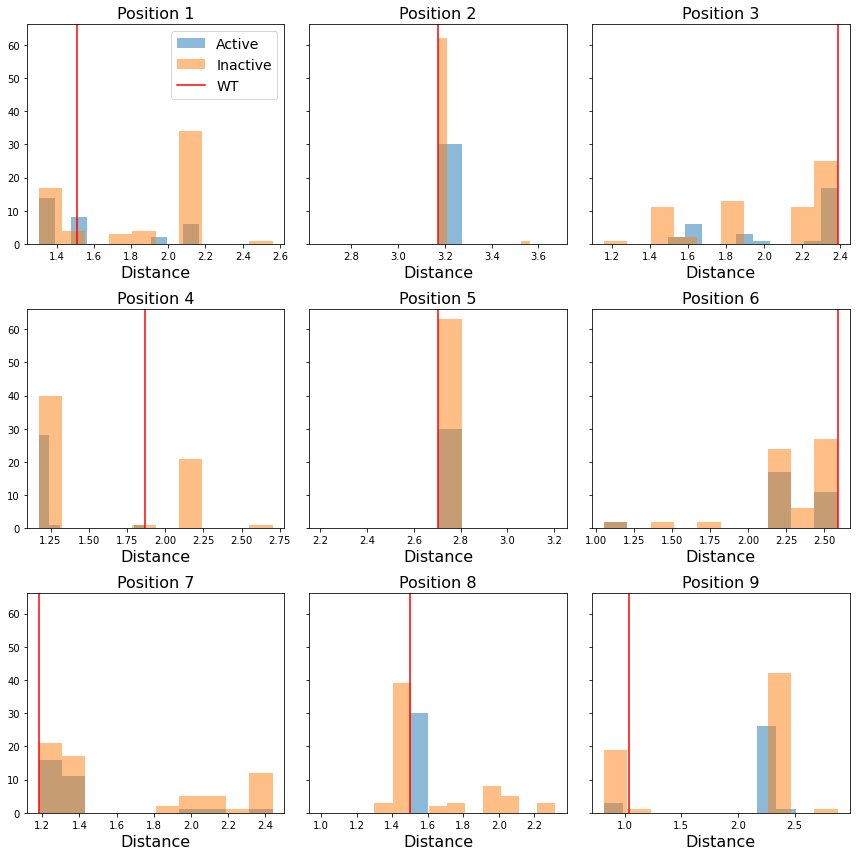

In [38]:
INDEX_TO_AA = list(pd.read_csv(MHCPWMFiles[0], index_col=0).columns)
AA_TO_INDEX = {aa: i for i, aa in enumerate(INDEX_TO_AA)}

HMC_and_length_to_PWM = {}
for pdb in MHCPWMs:
    HMC_and_length_to_PWM[pdb_to_MHC_and_length[pdb]] = MHCPWMs[pdb][0]


from Bio.Align import substitution_matrices

BLOSUM62 = substitution_matrices.load('BLOSUM62')
ABS_BLOSUM62 = np.abs(BLOSUM62)


def per_pos_distance(sequence, sub_matrix, pwm):
    assert len(sequence) == pwm.shape[0]
    assert pwm.shape[1] == 20
    
    per_pos_distance = []
    for pos, aa_seq in enumerate(sequence):
        per_pos_distance.append(np.sum([sub_matrix[aa_seq][INDEX_TO_AA[aa_comp_i]] * pwm[pos][aa_comp_i] for aa_comp_i in range(20)]))

    return per_pos_distance

nyeso_df = pd.read_csv('nyeso/NYES0_test_res_june05.csv')


# filter out unstim because it doesn't matter, it's just the control
nyeso_df = nyeso_df[nyeso_df['name'] != 'unstim']

# also filter out wt controls because they have no tcrdock_pae score
nyeso_df = nyeso_df[nyeso_df['name'] != 'NYESO_p95_wt']
nyeso_df = nyeso_df[nyeso_df['name'] != 'NYESO_p96_wt_V']

nyeso_wt = 'SLLMWITQC'

nyeso_MHC_PWM = HMC_and_length_to_PWM[('A*02:01', 9)]

nyeso_per_pos_distance_wt = per_pos_distance(nyeso_wt, ABS_BLOSUM62, nyeso_MHC_PWM)

nyeso_per_pos_distance_designed_list = []
for sequence in nyeso_df['sequence']:
    if isinstance(sequence, str):
        nyeso_per_pos_distance_designed_list.append(per_pos_distance(sequence, ABS_BLOSUM62, nyeso_MHC_PWM))
    else:
        nyeso_per_pos_distance_designed_list.append(np.nan)

nyeso_df['per_pos_distance'] = nyeso_per_pos_distance_designed_list

distances_per_pos = {}
for i in range(9):
    distances_per_pos[i] = []
    for distances in nyeso_per_pos_distance_designed_list:
        if isinstance(distances, list):
            distances_per_pos[i].append(distances[i])

distances_per_pos_active = {}
for i in range(9):
    distances_per_pos_active[i] = []
    for distances, resp in zip(nyeso_per_pos_distance_designed_list, nyeso_df['Resp']):
        if resp:
            if isinstance(distances, list):
                distances_per_pos_active[i].append(distances[i])

distances_per_pos_inactive = {}
for i in range(9):
    distances_per_pos_inactive[i] = []
    for distances, resp in zip(nyeso_per_pos_distance_designed_list, nyeso_df['Resp']):
        if not resp:
            if isinstance(distances, list):
                distances_per_pos_inactive[i].append(distances[i])

ncols = 3
nrows = 3
colsize = 4
rowsize = 4
fig, axs = plt.subplots(figsize=(ncols * colsize, nrows * rowsize), ncols=ncols, nrows=nrows, sharey=True)

for i, ax in enumerate(axs.flatten()):
    
    ax.hist(distances_per_pos_active[i], bins=10, alpha=0.5, label='Active')
    ax.hist(distances_per_pos_inactive[i], bins=10, alpha=0.5, label='Inactive')
    ax.axvline(nyeso_per_pos_distance_wt[i], color='red', label='WT')
    ax.set_title(f'Position {i+1}', fontsize=16)
    ax.set_xlabel(f'Distance', fontsize=16)

    if i == 0: ax.legend(fontsize=14)

plt.tight_layout()
plt.show()


